In [126]:
import numpy as np
import common_functions
from scipy.ndimage import rotate
import multiprocessing
import sys
import skimage as sk
import tifffile as tiff
import warnings
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import norm
import statistics
from copy import copy
from scipy.stats import ks_2samp, mannwhitneyu



In [3]:
time_dome = str(4)
dome_number = str(99)

folder_and_dome = str('./../../../../Desktop/dome'+dome_number+'_tp'+time_dome+'/'+dome_number+'_denoised_tp')

wd = folder_and_dome + time_dome

print(wd)

./../../../../Desktop/dome99_tp4/99_denoised_tp4


In [4]:
image = sk.io.imread(wd+'.tif')
image_r = common_functions.get_image_r(image)

sum_line = sk.io.imread(wd+'_sum_top_line_0.tif')
sum_line_r = common_functions.get_image_r(sum_line)

hull_line = sk.io.imread(wd+'_hull_top_line_0.tif')
hull_line_r = common_functions.get_image_r(hull_line)



In [277]:
# sum & mask profiles
total_line_r = common_functions.normalize_image(sum_line_r, 16*3)+common_functions.normalize_image(hull_line_r, 16)
# total_line_r[total_line_r >= 1] = 1

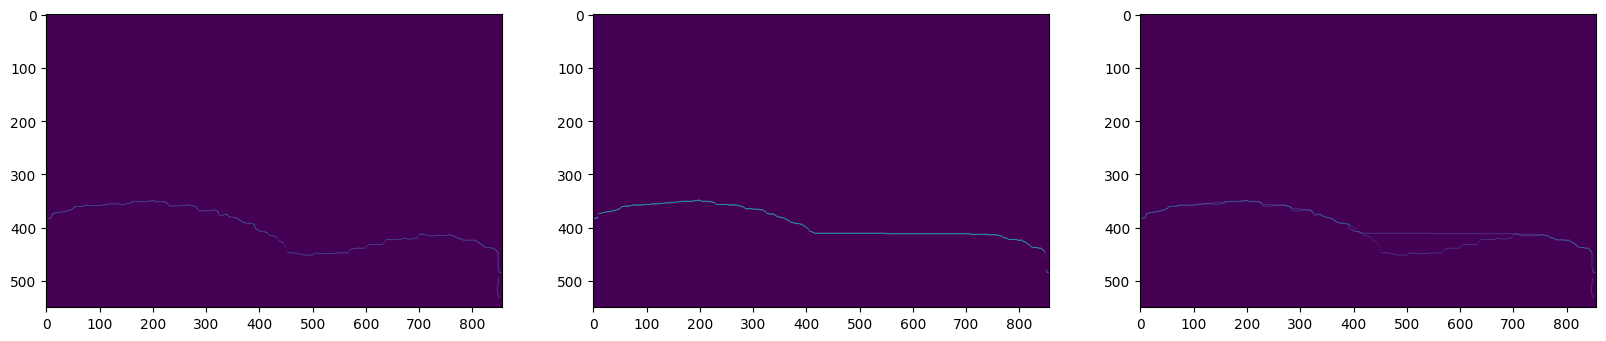

In [278]:
plt.figure(figsize=(20,20))

y = 10


plt.subplot(131)
plt.imshow(sum_line_r[y])

plt.subplot(132)
plt.imshow(hull_line_r[y])

plt.subplot(133)
plt.imshow(total_line_r[y])

In [279]:
gaussian_line_r = common_functions.get_3D_gaussian(total_line_r)
epithelial_r = gaussian_line_r*image_r

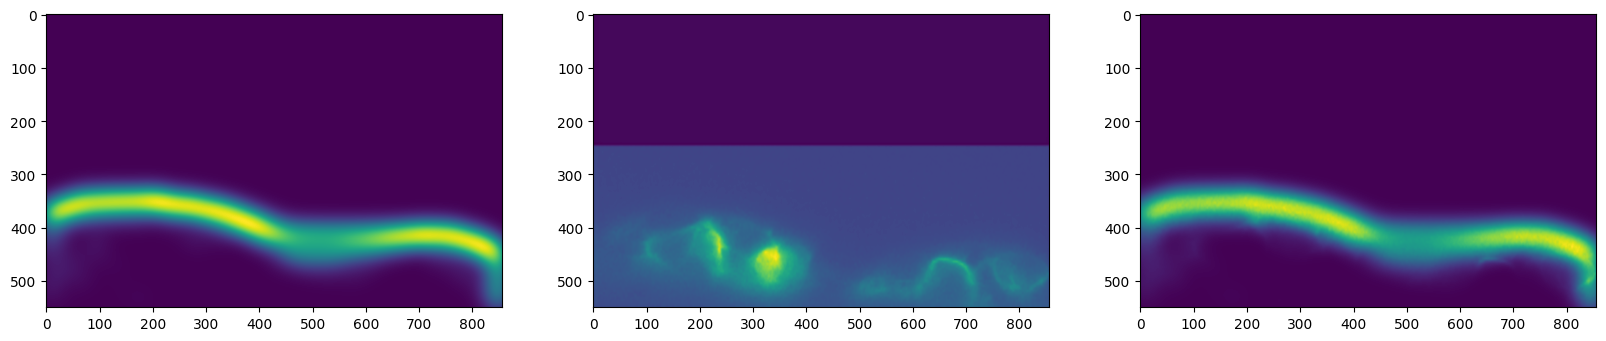

In [280]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(gaussian_line_r[y])
plt.subplot(132)
plt.imshow(image_r[y])
plt.subplot(133)
plt.imshow(common_functions.normalize_image(epithelial_r[10]))

In [214]:
def gamma_correction(image, gamma):

    current_max = image.max()

    image = common_functions.normalize_image(image,1)

    image = image**gamma

    image = common_functions.normalize_image(image, current_max)

    return image

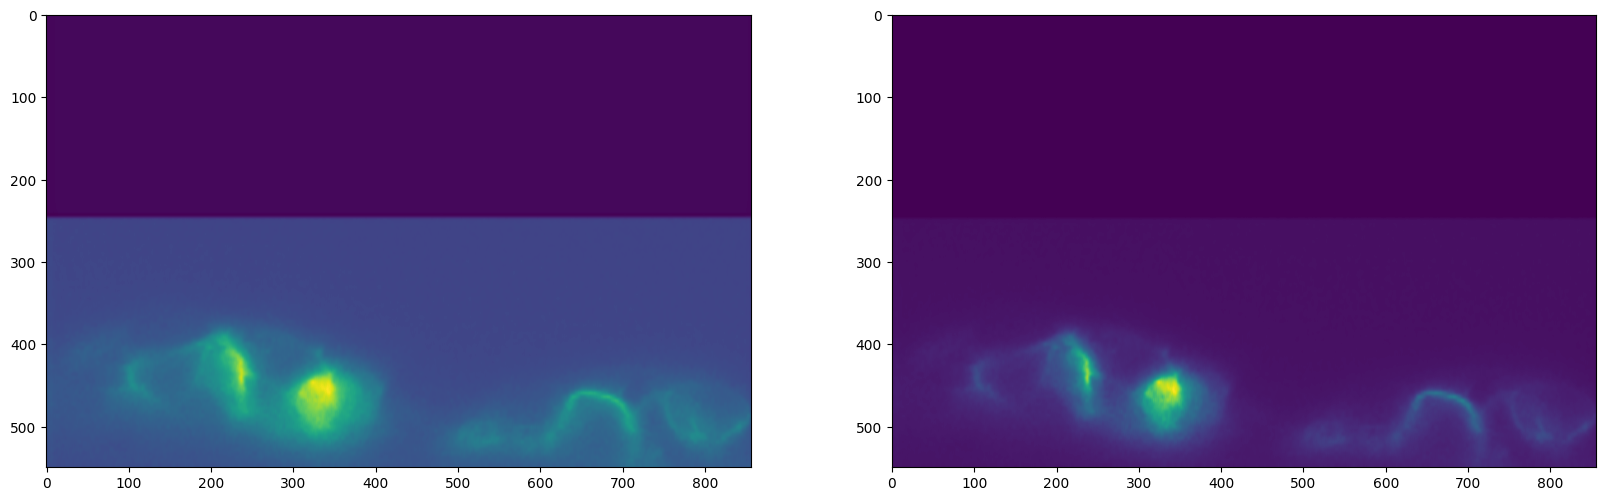

In [281]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_r[y])
plt.subplot(122)
plt.imshow(gamma_correction(image_r[y], 2))


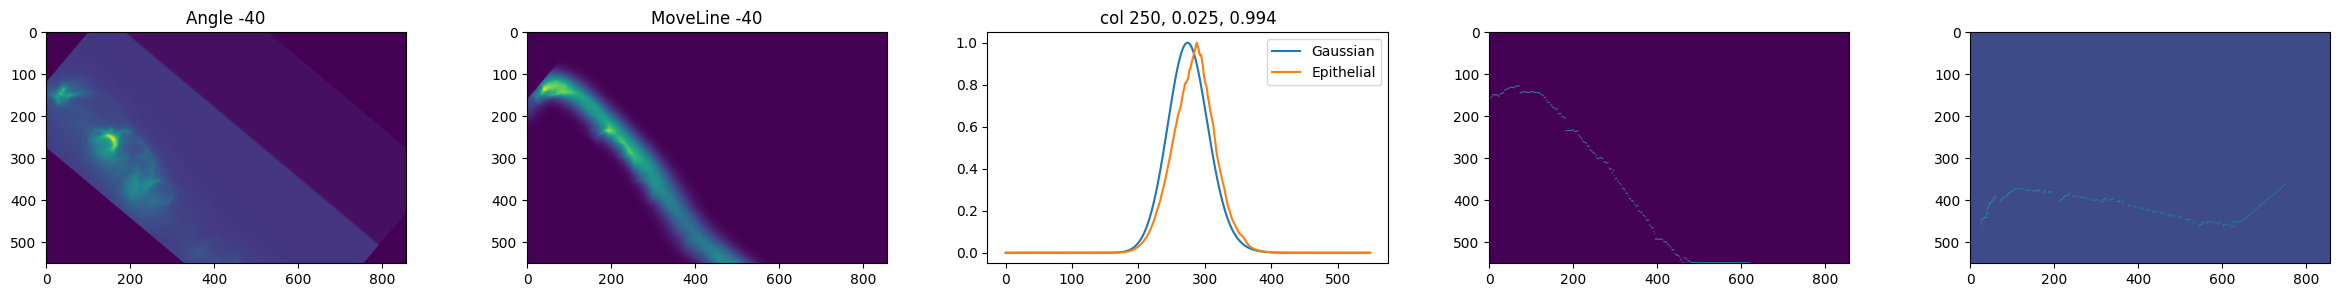

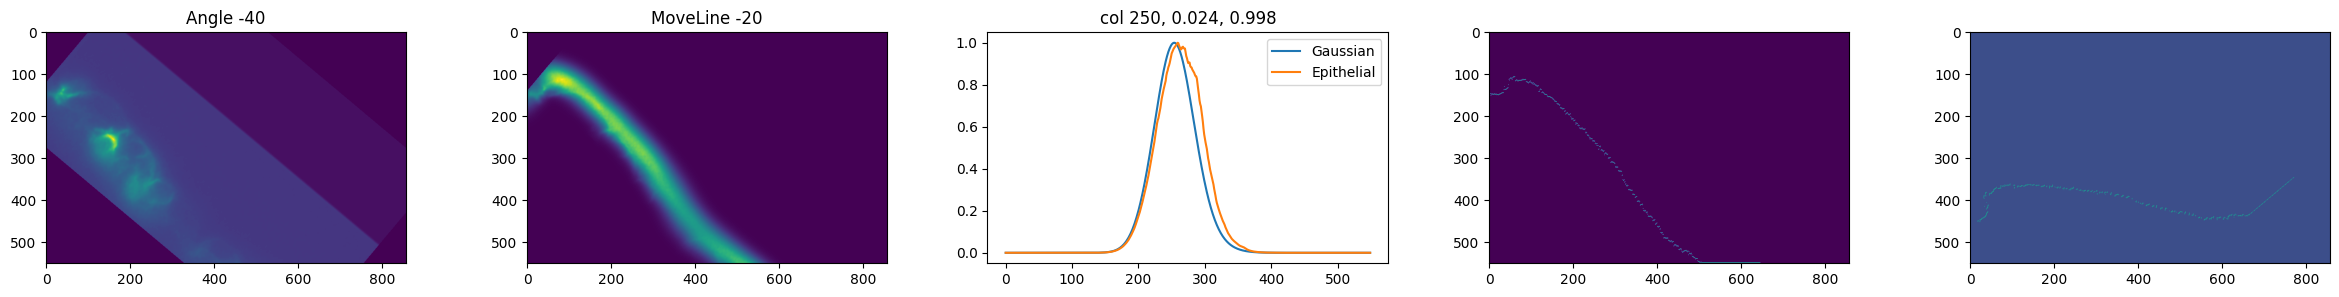

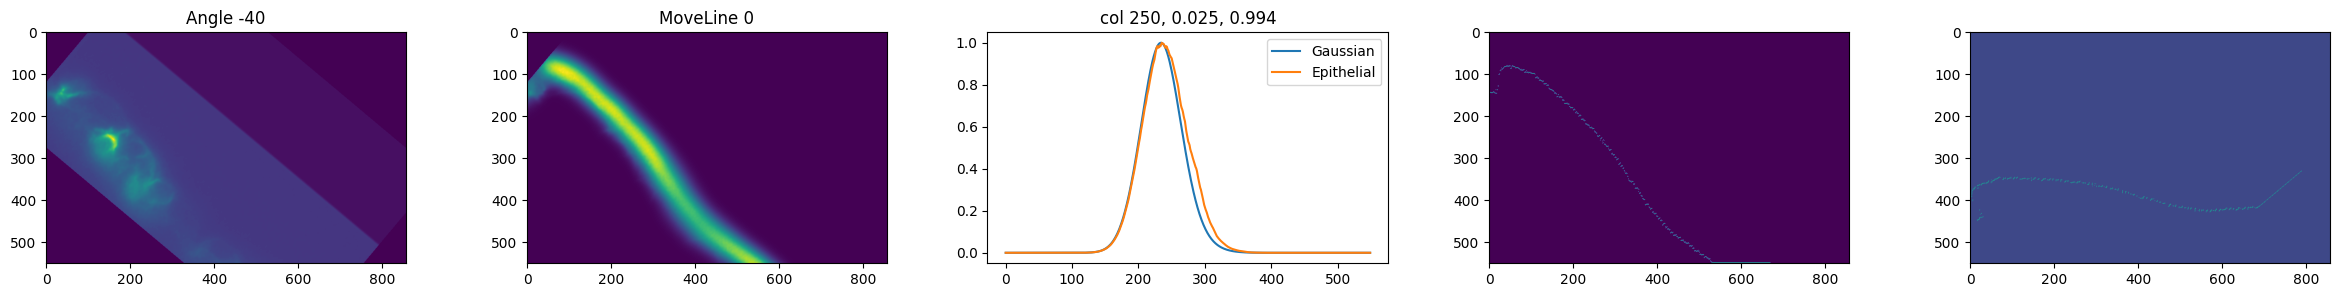

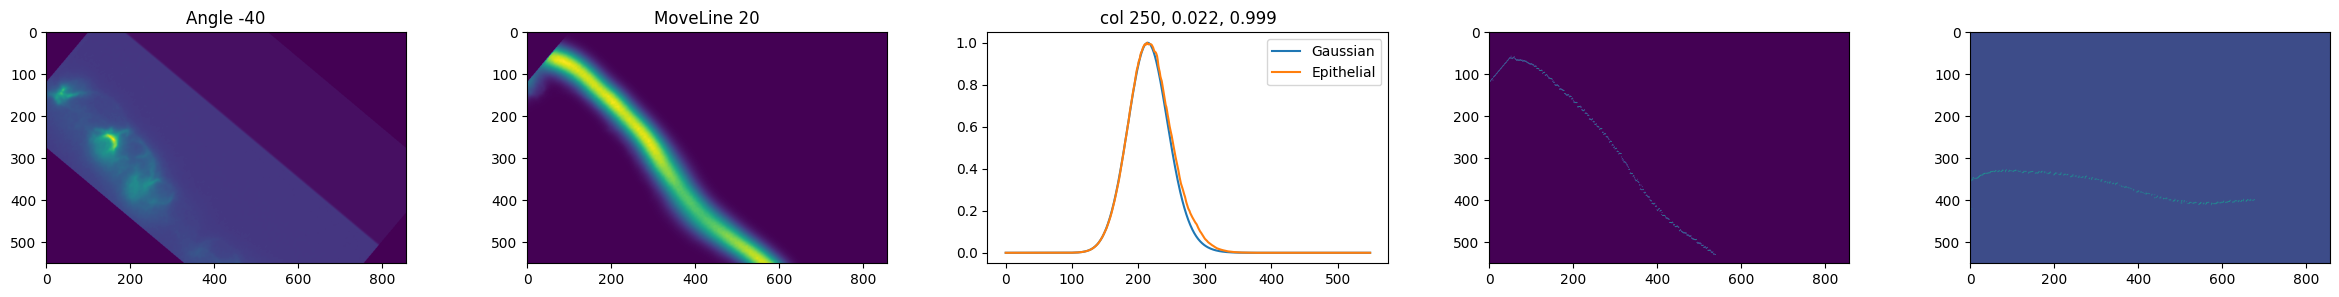

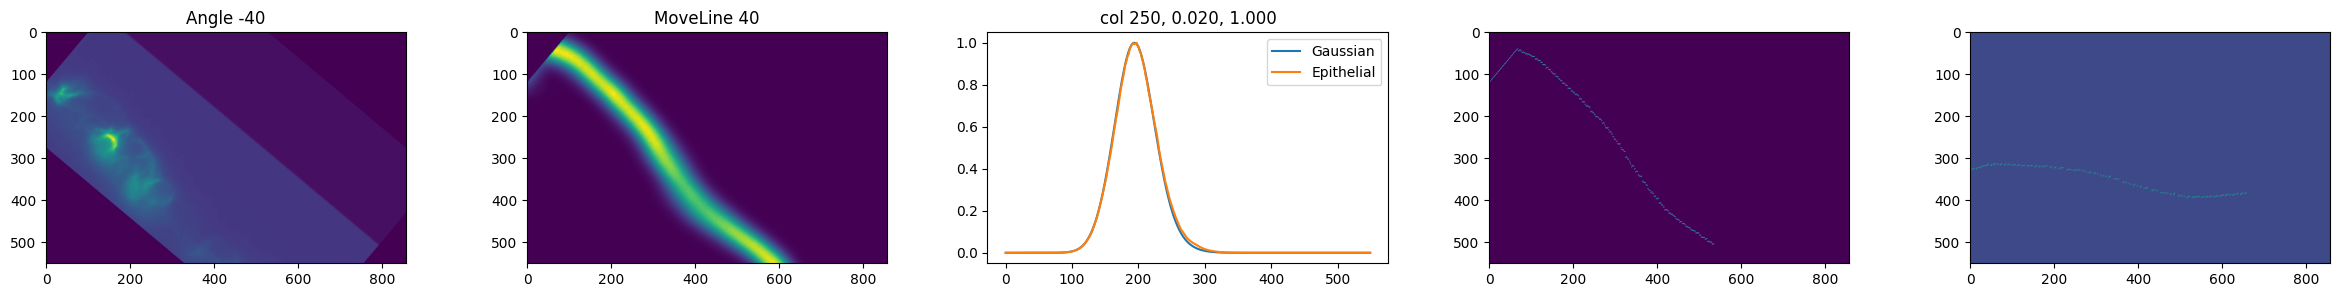

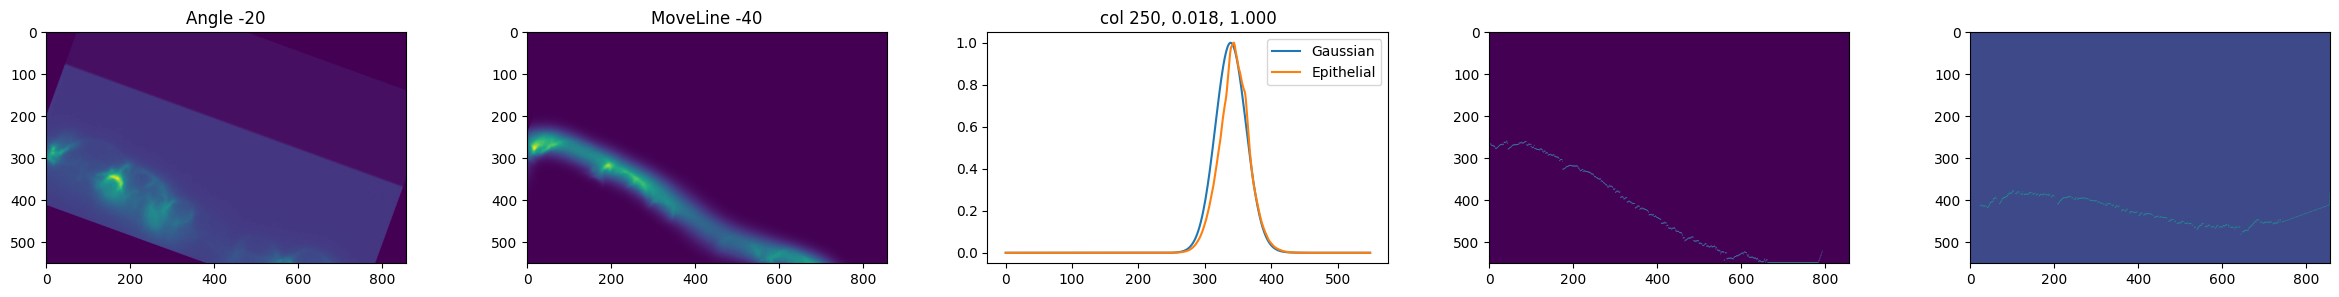

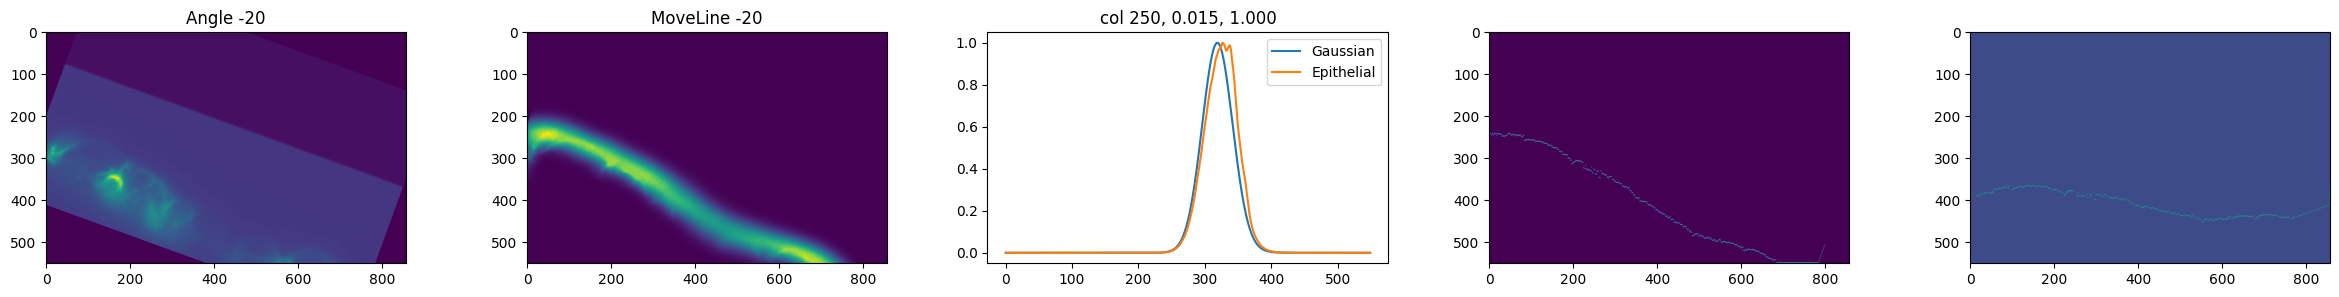

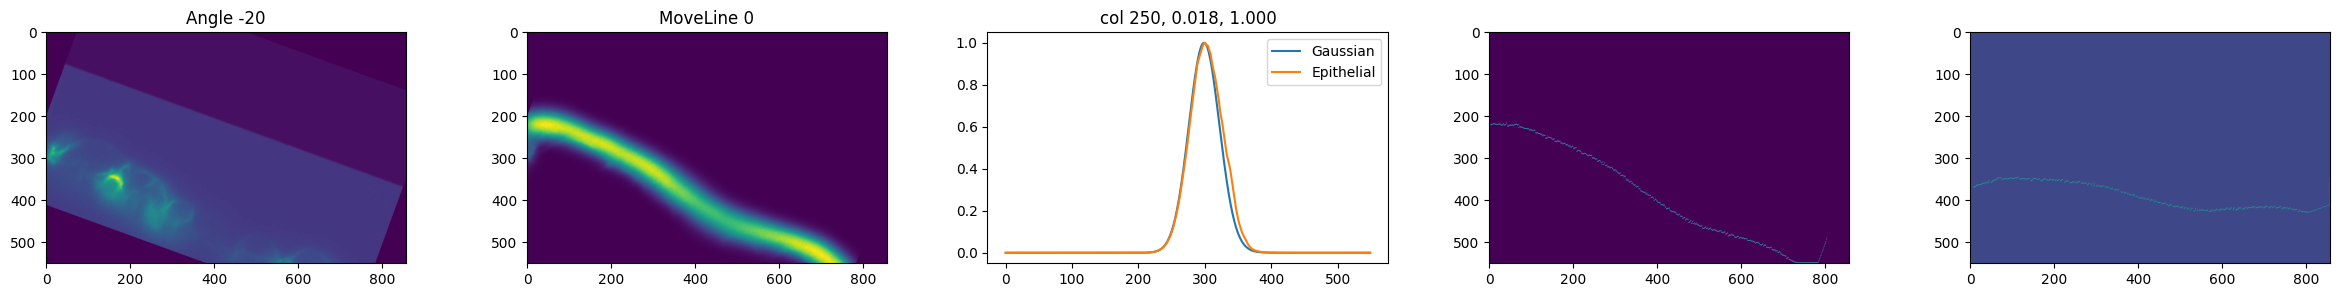

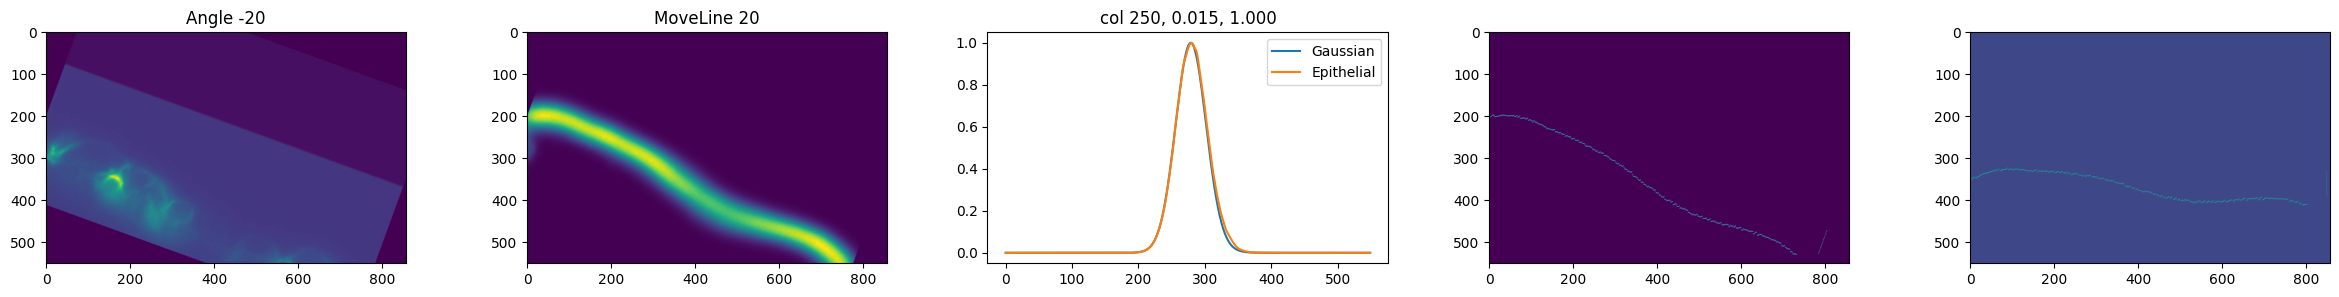

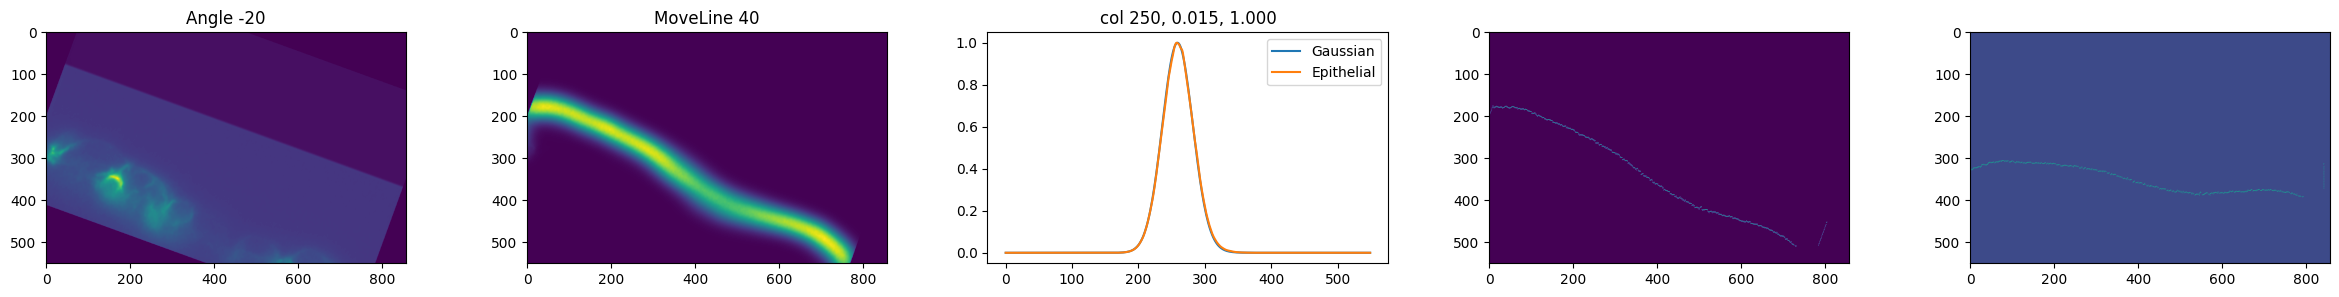

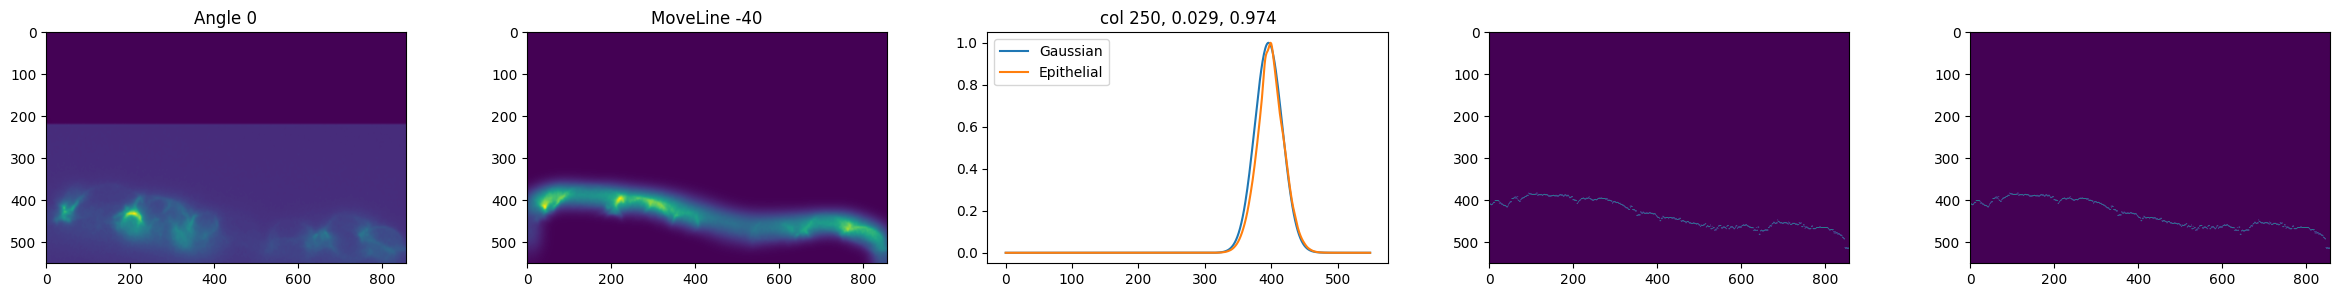

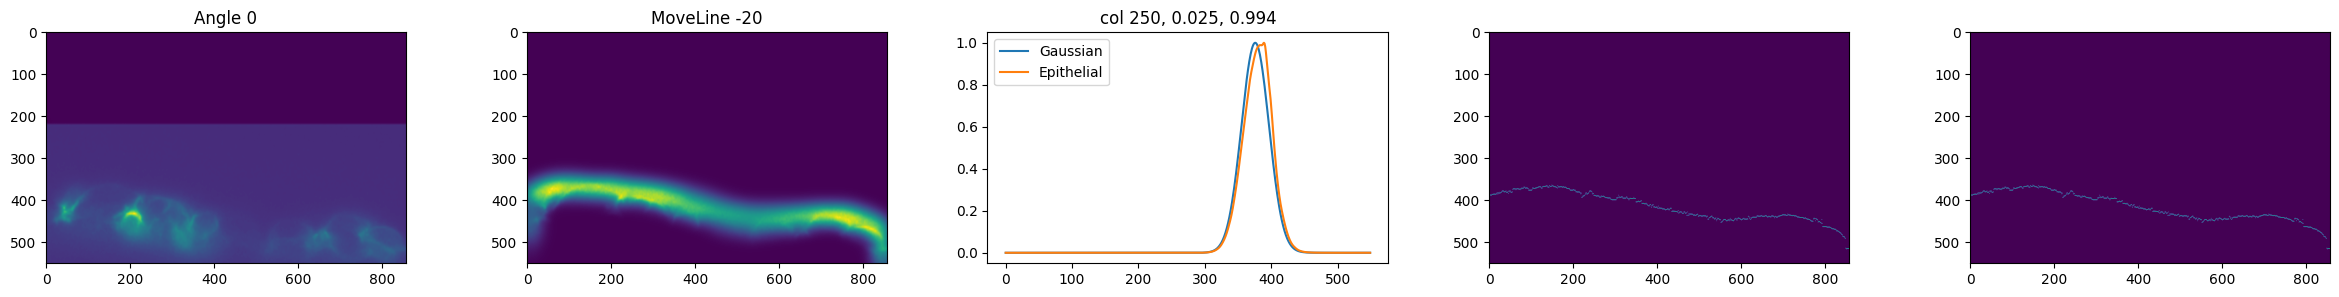

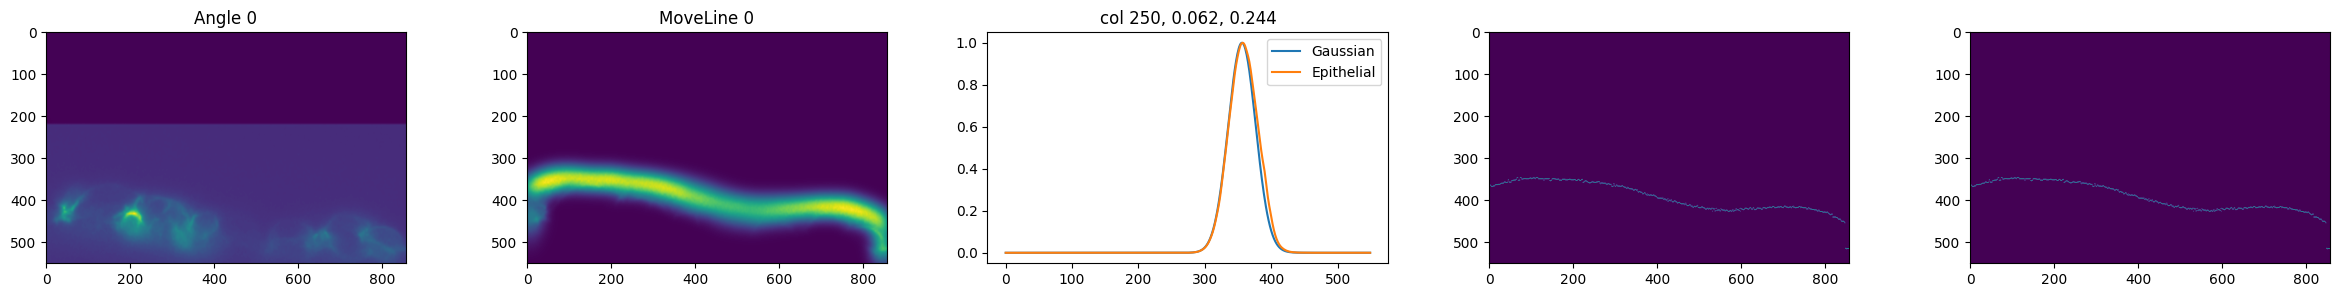

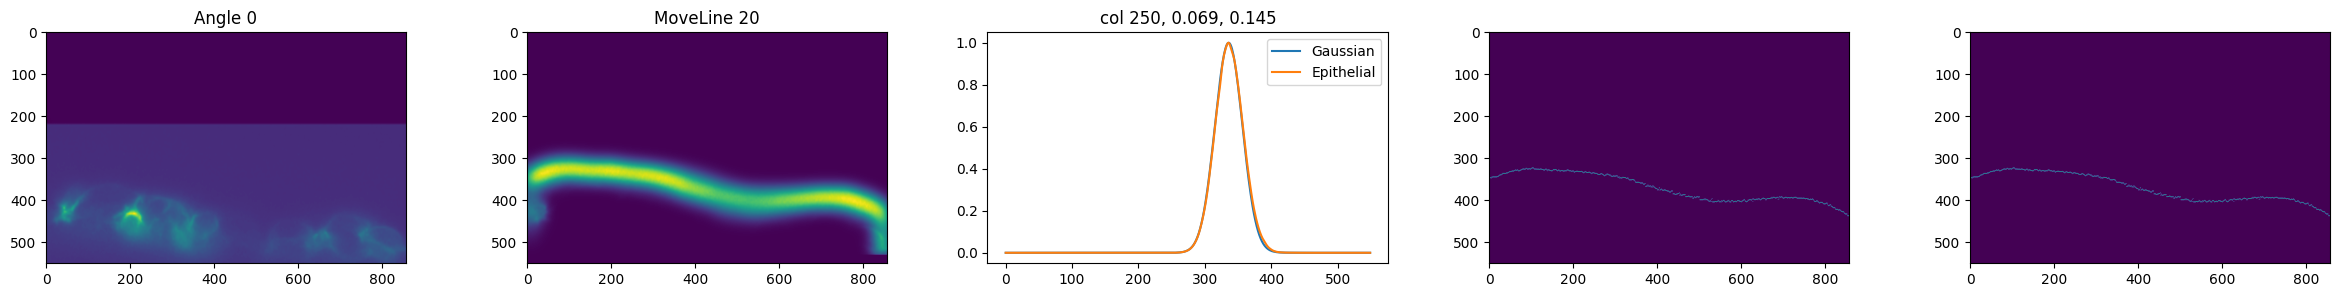

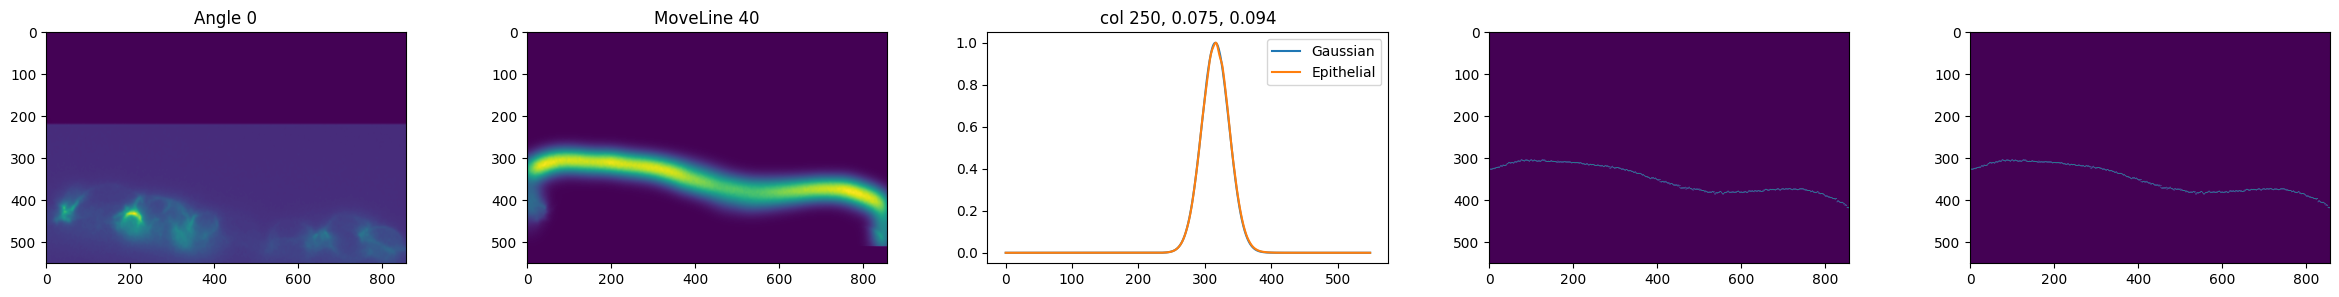

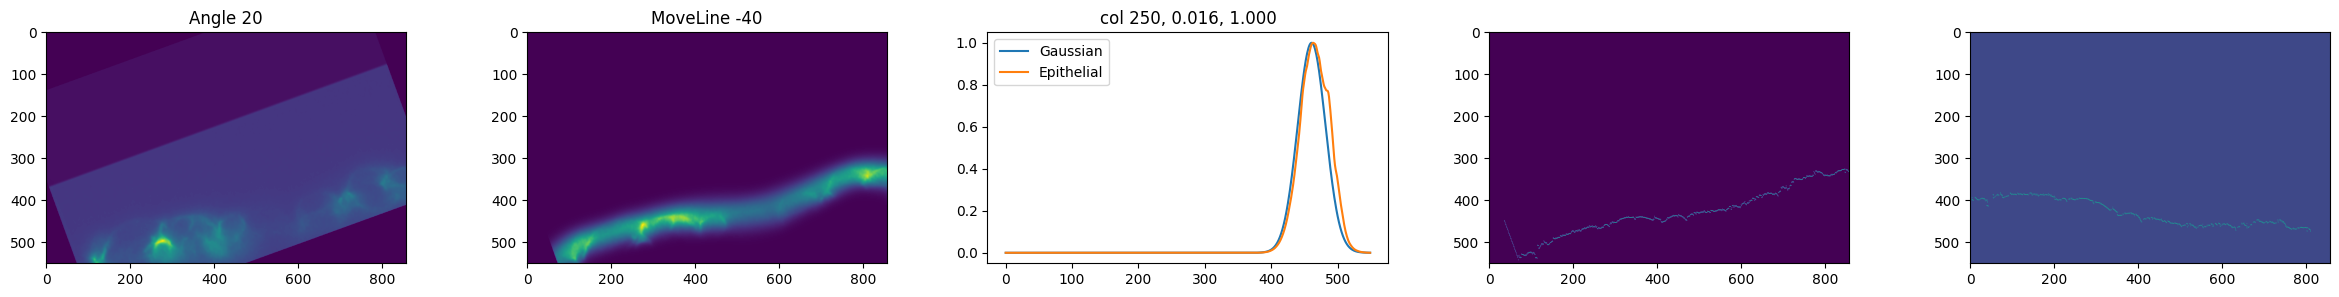

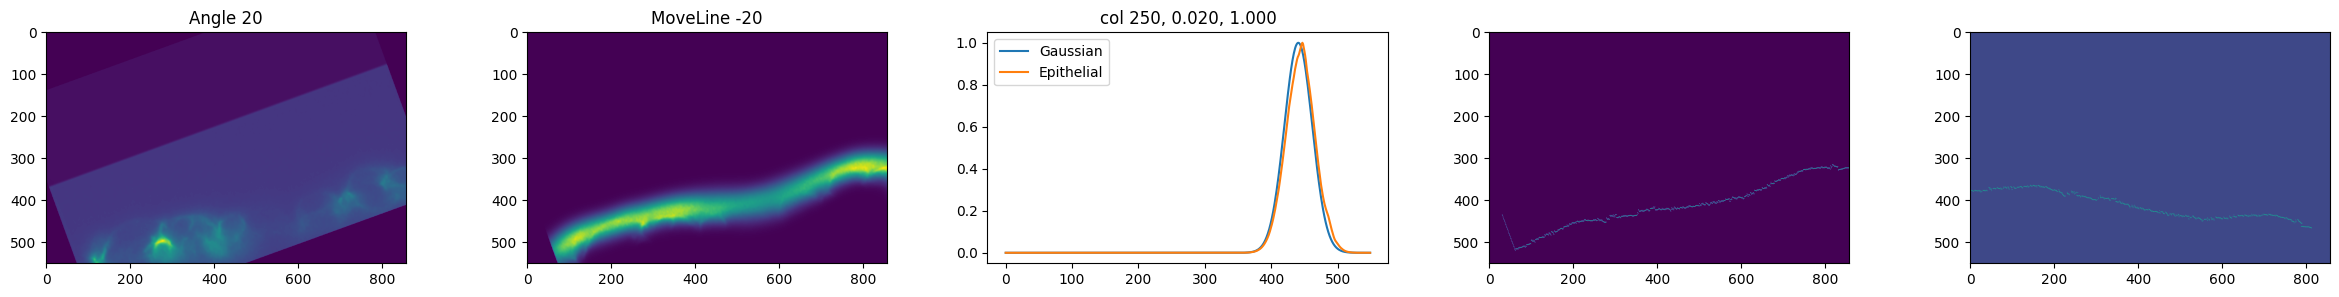

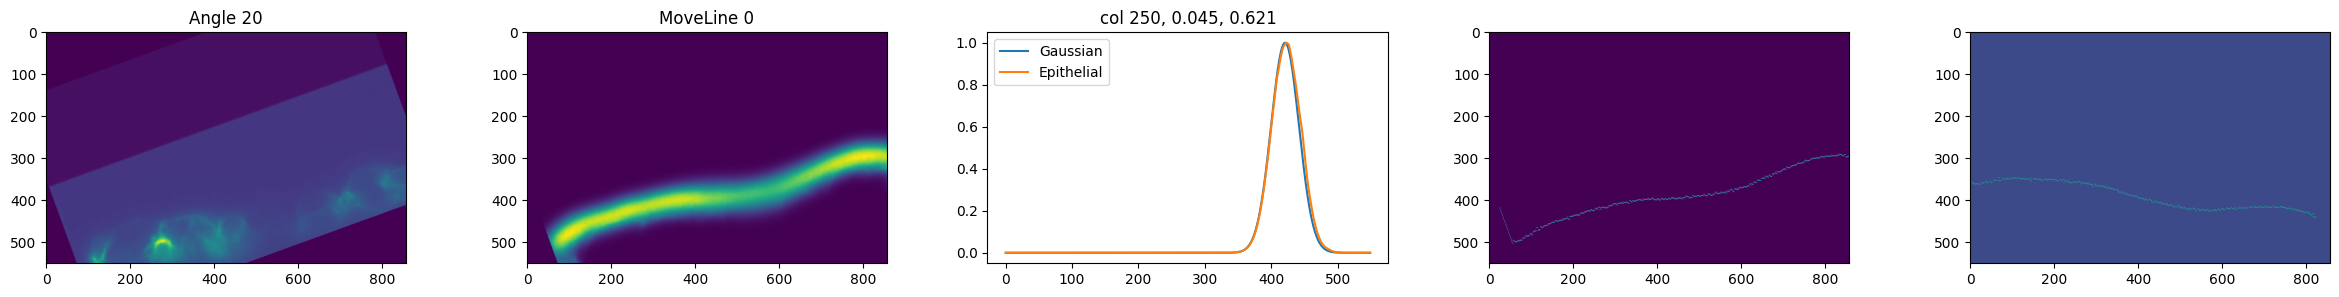

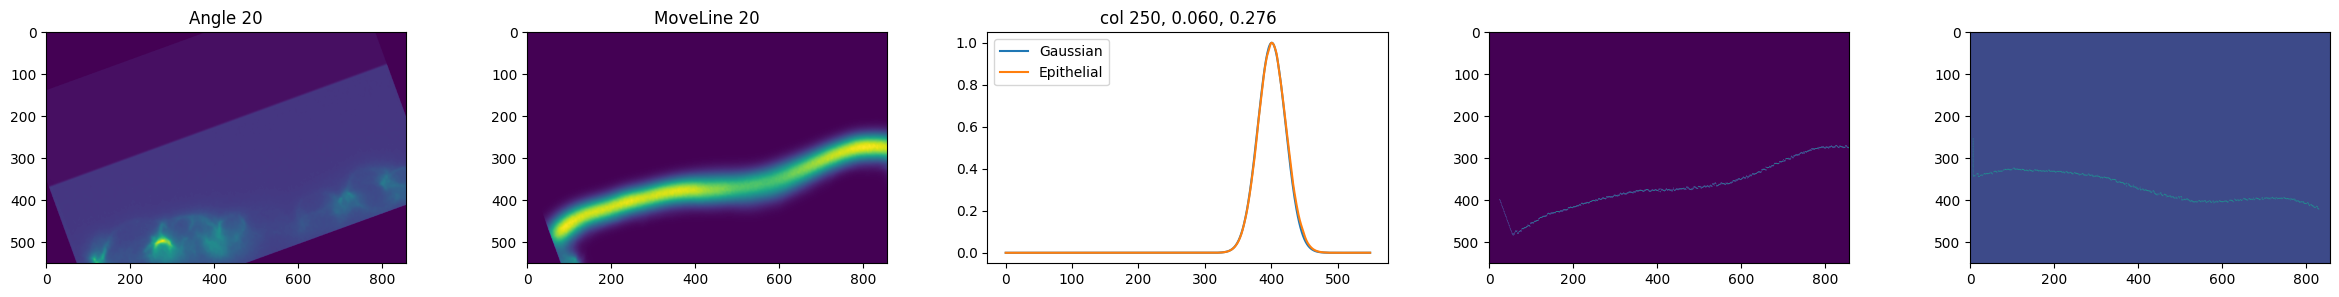

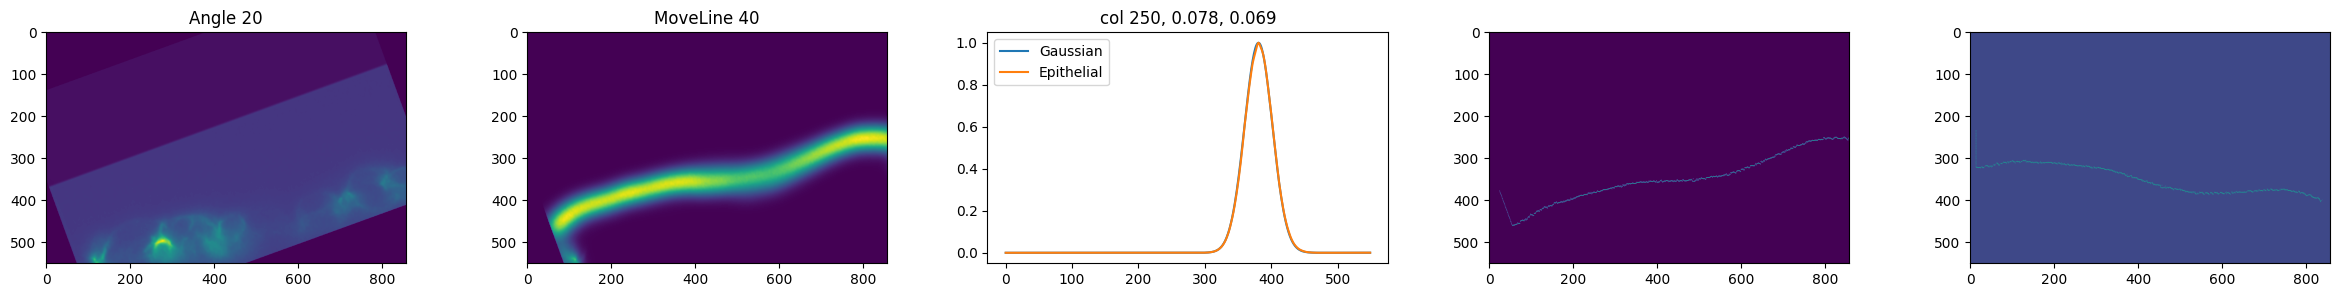

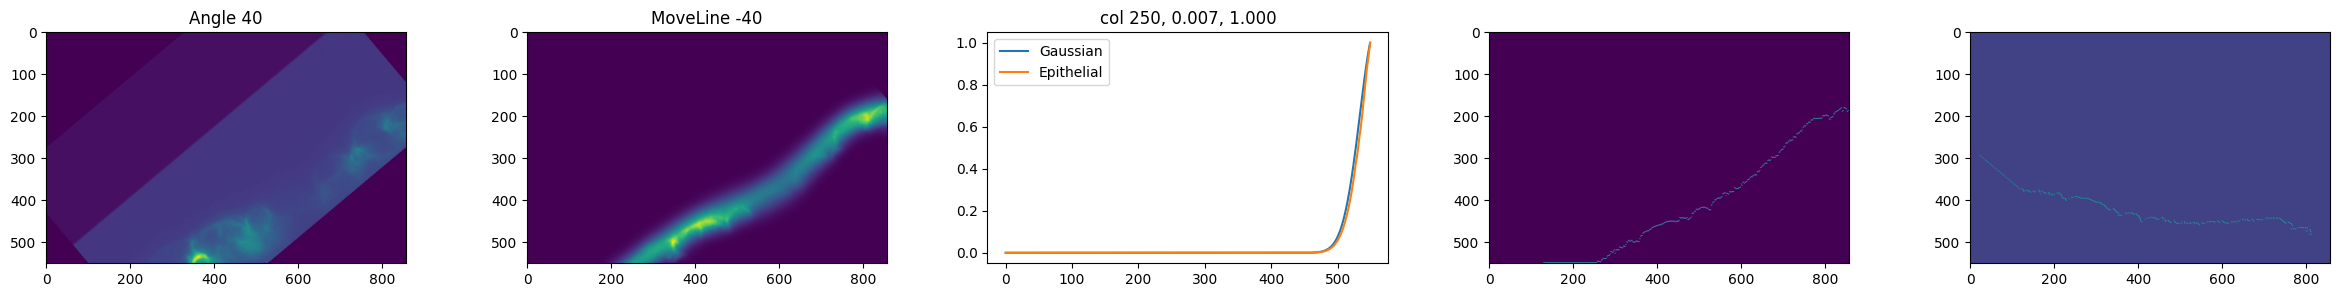

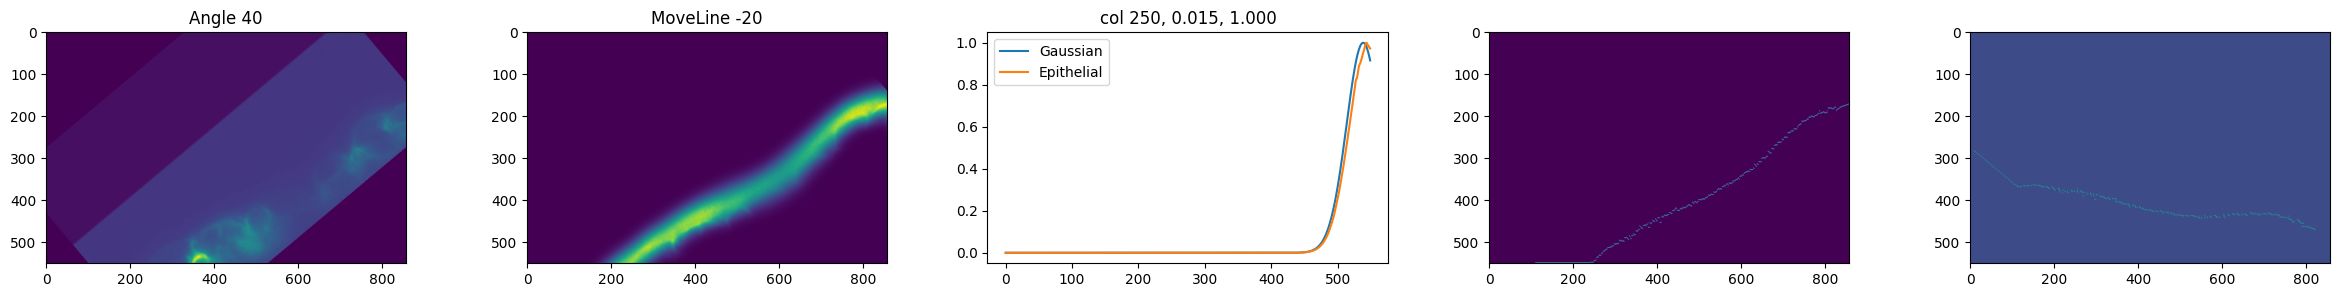

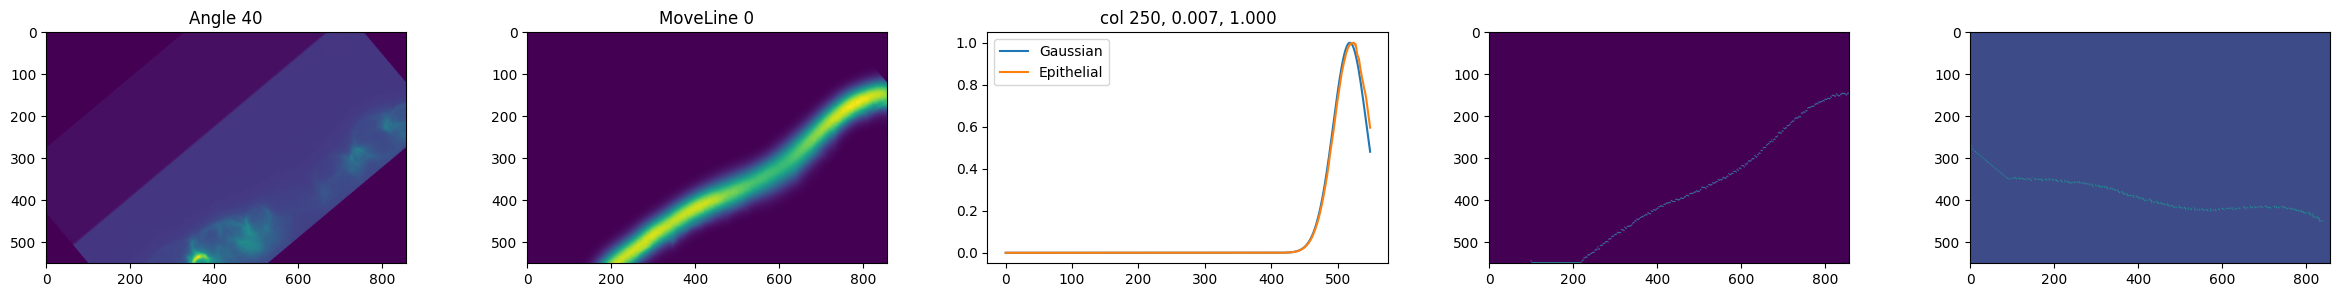

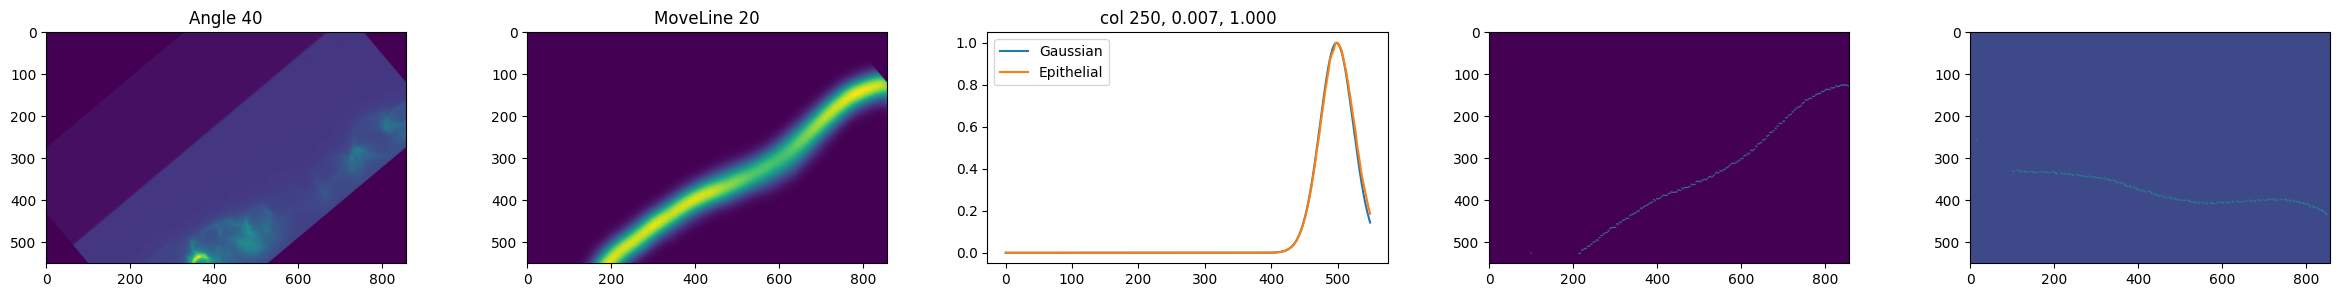

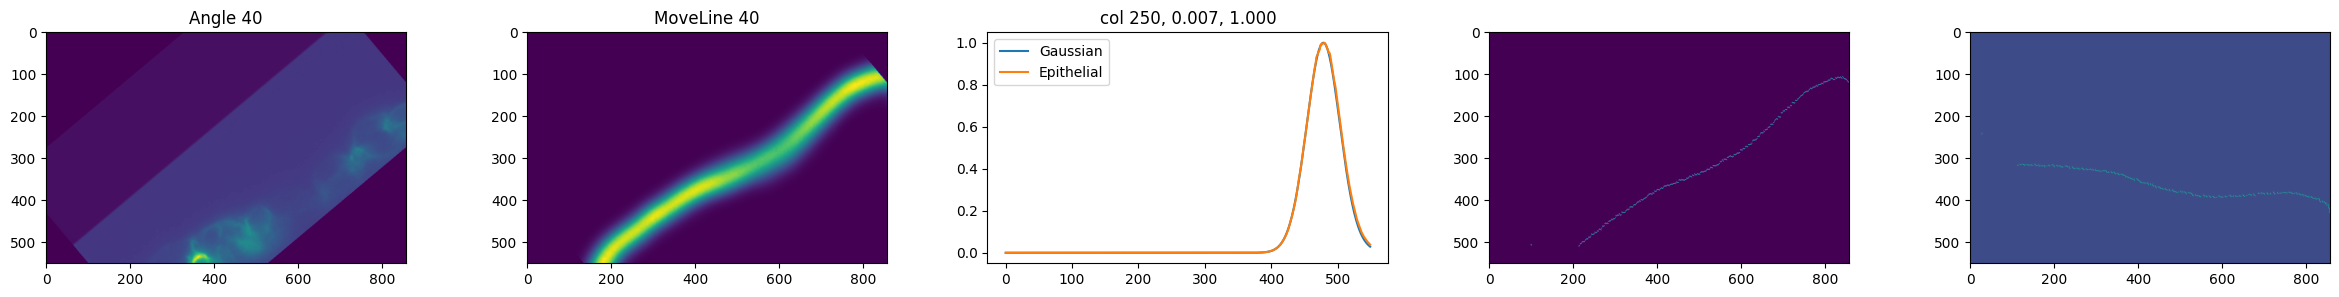

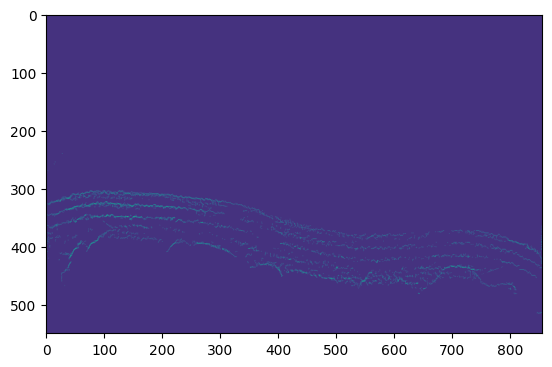

In [355]:
def find_maximus(epithelial, moveLine, margin=5):

    max_intensity_indices =  np.argmax(epithelial, axis=0)

    apical = np.zeros(epithelial.shape)
    apical[max_intensity_indices, np.array(list(range(epithelial.shape[1])))] = 1

    # print(-moveLine-margin)

    if moveLine-margin > 0:
        apical[-moveLine-margin:, :] = 0

    return apical

# def fucking_apical_backup(image, gaussian, total_line, angle = 40, moveLine = 20, plots=False):

    total_apical = np.zeros((image.shape))

    angles = [i for i in range(-angle, angle+1, 20)]

    moveLines = [i for i in range(-moveLine, moveLine+1, 20)]

    p_values_array = np.zeros((len(angles)*len(moveLines), image.shape[1]))

    image = gamma_correction(image, 0.5)

    c = 0

    for angle in angles:
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)
        rot_total_line = rotate(total_line, angle, reshape=True)

        for moveLine in moveLines:

            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)
            rot_total_line_up = common_functions.move2D_array(rot_total_line, moveLine)

            y_0 = np.array(rot_gaussian.shape[0])/2-np.array(image.shape[0])/2
            y_1 = np.array(rot_gaussian.shape[0])/2+np.array(image.shape[0])/2
            x_0 = np.array(rot_gaussian.shape[1])/2-np.array(image.shape[1])/2
            x_1 = np.array(rot_gaussian.shape[1])/2+np.array(image.shape[1])/2

            y_0, y_1, x_0, x_1 = int(y_0), int(y_1), int(x_0), int(x_1)

            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]
            rot_total_line_up = rot_total_line_up[y_0:y_1, x_0:x_1]
            rot_total_line_up = common_functions.normalize_image(rot_total_line_up, 255)


            rot_epithelial = rot_image*rot_gaussian_up

            margin = 0
            apical = find_maximus(rot_epithelial, moveLine, margin)

            ## Check distance to origin of gaussian and also compare the intensity at a given point with its neighbour to check it is not background?
            for x in range(rot_epithelial.shape[1]):
                column = apical[:, x]
                lines = rot_total_line_up[:, x]
                lines[lines >= 1] = 1
                if sum(column) == 0:
                    pass
                else:
                    position_of_dot = np.where(column == 1)[0][0]
                    
                    position_of_lines = np.where(lines >= 1)[0]

                    # if len(position_of_lines):
                    #     position_of_lines = position_of_lines.mean()
                    
                    if not len(position_of_lines):
                        position_of_lines = np.array([0])




                    # Center point coordinates
                    center_y, center_x = position_of_dot, x

                    # Define the size of the neighborhood (e.g., 3x3)
                    neighborhood_size = 40
                    half_size = neighborhood_size // 2

                    # Extract the neighborhood
                    neighborhood = rot_image[
                        max(center_y - half_size, 0) : min(center_y + half_size + 1, rot_image.shape[0]),
                        max(center_x - half_size, 0) : min(center_x + half_size + 1, rot_image.shape[1])
                    ]

                    # mean_value = np.mean(neighborhood)

                    evaluate = 400

                    # print(f'value on image {rot_image[center_y, center_x]}, mean_value {mean_value}, position of dot {position_of_dot}, lines {position_of_lines}') if x == evaluate else None
                    
                    # print(abs(position_of_lines-position_of_dot)) if x == 550 else None

                    # filter_margin_of_intensity = abs(1-rot_image[center_y, center_x] / mean_value) < 0.05

                    # print(f'Filter intensity {filter_margin_of_intensity}, {abs(1-rot_image[center_y, center_x] / mean_value)}') if x == evaluate else None

                    # filter_margin_of_distance = abs(position_of_lines-position_of_dot) <= 0.05*len(column) ## Done with the mean of position_of_lines (not removing the close points to one line)

                    # filter_margin_of_distance = abs(position_of_lines-position_of_dot).min()/len(column) < 0.5 # Try to get the smallest distance

                    # print(f'Filter distance {filter_margin_of_distance}, {abs(position_of_lines-position_of_dot).min()}') if x == evaluate else None

                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    # rot_epithelial = common_functions.gaussian_2D(rot_epithelial, 0.3)
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])

                    ks_stat, p_value = ks_2samp(epithelial_distribution, gaussian_distribution)
                    print(ks_stat, p_value) if x == evaluate else None

                    p_values_array[c, x] = p_value


                    # filter_distribution = p_value > 0.95

                    # print(f'Filter distribution {filter_distribution}, p_value {p_value}') if x == evaluate else None



                    

                    
                    # if filter_distribution:
                    #     # print('no')
                    #     apical[center_y, center_x] = 0

                    # print(image[center_y, center_x], mean_value, center_y, center_x)

            
            if plots:
                cols=5
                rows=1
                plt.figure(figsize=(30, 3))
                plt.subplot(rows, cols, 1)
                plt.title(f'Angle {angle}')
                plt.imshow(rot_image)
                plt.subplot(rows, cols, 2)
                plt.title(f'MoveLine {moveLine}')
                plt.imshow(rot_epithelial)
                plt.subplot(rows, cols, 3)
                plt.title(f'Evaluation at {evaluate}, {p_value:.4f}, {ks_stat:.2f}')
                plt.plot(gaussian_distribution, label='Gaussian')
                plt.plot(epithelial_distribution, label='Epithelial')
                plt.legend()
                plt.subplot(rows, cols, 4)
                plt.imshow(rot_total_line_up)
                plt.subplot(rows, cols, 5)
                plt.imshow(apical)
                if moveLine-margin >= 1:
                    plt.axhline(apical.shape[0]-moveLine-margin)

            c+=1


            # apical = apical * rot_gaussian_up
            apical = rotate(apical, -angle, reshape=False)

            total_apical += apical





    return total_apical, p_values_array



# def fucking_apical(image, gaussian, angles, moveLines, plots=False):

    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    total_apical = np.zeros((image.shape))

    # image = gamma_correction(image, 2)

    c = 0

    apical_i = np.zeros((len(angles)*len(moveLines), image.shape[0], image.shape[1]))
    

    for angle in angles:
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)

        p_values_ml = np.zeros((len(moveLines), rot_image.shape[1]))

        m = 0

        for moveLine in moveLines:

            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)


            y_0 = np.array(rot_gaussian.shape[0])/2-np.array(image.shape[0])/2
            y_1 = np.array(rot_gaussian.shape[0])/2+np.array(image.shape[0])/2
            x_0 = np.array(rot_gaussian.shape[1])/2-np.array(image.shape[1])/2
            x_1 = np.array(rot_gaussian.shape[1])/2+np.array(image.shape[1])/2

            y_0, y_1, x_0, x_1 = int(y_0), int(y_1), int(x_0), int(x_1)

            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            rot_epithelial = rot_image*rot_gaussian_up

            margin = 0
            apical_rot_ml = find_maximus(rot_epithelial, moveLine, margin)
            apical_i[c] = apical_rot_ml
            c+=1

            for x in range(rot_epithelial.shape[1]):
                column = apical_rot_ml[:, x]

                if sum(column) == 0:
                    pass
                else:
                    position_of_dot = np.where(column == 1)[0][0]

                    evaluate = '500'

                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    # rot_epithelial = common_functions.gaussian_2D(rot_epithelial, 0.3)
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])

                    ks_stat, p_value = ks_2samp(epithelial_distribution, gaussian_distribution)
                    print(f'{evaluate}, angle {angle}, move line {moveLine}, {ks_stat:.2f}, p value {p_value:.2f}') if x == evaluate else None

                    p_values_ml[m,x] = p_value


            

            m+=1


                    
            
            if plots:
                evaluate = int(evaluate)
                cols=5
                rows=1
                plt.figure(figsize=(30, 3))
                plt.subplot(rows, cols, 1)
                plt.title(f'Angle {angle}')
                plt.imshow(rot_image)
                plt.subplot(rows, cols, 2)
                plt.title(f'MoveLine {moveLine}')
                plt.imshow(rot_epithelial)
                plt.subplot(rows, cols, 3)
                ks_stat, p_value = ks_2samp(common_functions.normalize_image(rot_epithelial[:, evaluate]), common_functions.normalize_image(rot_gaussian_up[:, evaluate]))
                plt.title(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
                plt.plot(common_functions.normalize_image(rot_gaussian_up[:, evaluate]), label='Gaussian')
                plt.plot(common_functions.normalize_image(rot_epithelial[:, evaluate]), label='Epithelial')
                plt.legend()
                plt.subplot(rows, cols, 4)
                plt.imshow(rot_gaussian_up)
                plt.subplot(rows, cols, 5)
                plt.imshow(rotate(apical_rot_ml, -angle, reshape=False))
                if moveLine-margin >= 1:
                    plt.axhline(apical_rot_ml.shape[0]-moveLine-margin)


            

        p_values_ml[p_values_ml < p_values_ml.mean(axis=0, keepdims=True)] = True
        p_values_ml[p_values_ml != True] = False

        # print(p_values_ml.shape)
        mask_expanded = np.repeat(p_values_ml[:, np.newaxis, :], apical_i.shape[1], axis=1)
        # print(mask_expanded.shape)
        # print(apical_i.shape)

    
        apical_i[mask_expanded == False] = 0

        apical_i = np.sum(apical_i, axis=0)
                
            # apical = apical_rot_ml

            # c+=1
            # m+=1




        apical = rotate(apical_i, -angle, reshape=False)

        total_apical += apical





    return total_apical




# def fucking_apical(image, gaussian, angles, moveLines, plots=False):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    total_apical = np.zeros(image.shape)
    apical_i = np.zeros((len(angles) * len(moveLines), image.shape[0], image.shape[1]))
    c = 0

    for angle in angles:
        # Rotate image and Gaussian
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)
        
        p_values_ml = np.zeros((len(moveLines), rot_image.shape[1]))

        for m, moveLine in enumerate(moveLines):
            # Move Gaussian and crop to match the image shape
            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)
            y_0 = (rot_gaussian.shape[0] - image.shape[0]) // 2
            y_1 = y_0 + image.shape[0]
            x_0 = (rot_gaussian.shape[1] - image.shape[1]) // 2
            x_1 = x_0 + image.shape[1]
            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            # Calculate rotated epithelial
            rot_epithelial = rot_image * rot_gaussian_up
            apical_rot_ml = find_maximus(rot_epithelial, moveLine, 0)
            apical_i[c] = apical_rot_ml
            c += 1

            for x in range(rot_epithelial.shape[1]):
                column = apical_rot_ml[:, x]
                if np.sum(column) > 0:
                    position_of_dot = np.where(column == 1)[0][0]
                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])
                    _, p_value = ks_2samp(epithelial_distribution, gaussian_distribution)
                    p_values_ml[m, x] = p_value

            if plots:
                plot_results(angle, moveLine, evaluate, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml)

        # Apply mask to p_values_ml
        mean_p_values = p_values_ml.mean(axis=0, keepdims=True)
        p_values_ml = np.where(p_values_ml < mean_p_values, True, False)
        
        # Expand mask and apply to apical_i
        mask_expanded = np.repeat(p_values_ml[:, np.newaxis, :], apical_i.shape[1], axis=1)
        apical_i[mask_expanded == False] = 0

        # Sum across all layers
        summed_apical_i = np.sum(apical_i, axis=0)
        
        # Rotate back and add to total_apical
        total_apical += rotate(summed_apical_i, -angle, reshape=False)

    return total_apical

# def plot_results(angle, moveLine, evaluate, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml):
    evaluate = int(evaluate)
    cols = 5
    rows = 1
    plt.figure(figsize=(30, 3))
    plt.subplot(rows, cols, 1)
    plt.title(f'Angle {angle}')
    plt.imshow(rot_image)
    plt.subplot(rows, cols, 2)
    plt.title(f'MoveLine {moveLine}')
    plt.imshow(rot_epithelial)
    plt.subplot(rows, cols, 3)
    ks_stat, p_value = ks_2samp(common_functions.normalize_image(rot_epithelial[:, evaluate]),
                                common_functions.normalize_image(rot_gaussian_up[:, evaluate]))
    plt.title(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
    plt.plot(common_functions.normalize_image(rot_gaussian_up[:, evaluate]), label='Gaussian')
    plt.plot(common_functions.normalize_image(rot_epithelial[:, evaluate]), label='Epithelial')
    plt.legend()
    plt.subplot(rows, cols, 4)
    plt.imshow(rot_gaussian_up)
    plt.subplot(rows, cols, 5)
    plt.imshow(rotate(apical_rot_ml, -angle, reshape=False))
    if moveLine - 0 >= 1:
        plt.axhline(apical_rot_ml.shape[0] - moveLine - 0)



def fucking_apical(image, gaussian, angles, moveLines, plots=False):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    total_apical = np.zeros(image.shape)
    apical_i = np.zeros((len(moveLines), image.shape[0], image.shape[1]))

    for angle in angles:
        # Rotate image and Gaussian
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)
        
        p_values_ml = np.zeros((len(moveLines), rot_image.shape[1]))

        for m, moveLine in enumerate(moveLines):
            # Move Gaussian and crop to match the image shape
            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)
            y_0 = (rot_gaussian.shape[0] - image.shape[0]) // 2
            y_1 = y_0 + image.shape[0]
            x_0 = (rot_gaussian.shape[1] - image.shape[1]) // 2
            x_1 = x_0 + image.shape[1]
            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            # Calculate rotated epithelial
            rot_epithelial = rot_image * rot_gaussian_up
            apical_rot_ml = find_maximus(rot_epithelial, moveLine, margin=0)
            apical_i[m] = apical_rot_ml

            for x in range(rot_epithelial.shape[1]):
                column = apical_rot_ml[:, x]
                if np.sum(column) > 0:
                    position_of_dot = np.where(column == 1)[0][0]
                    gaussian_distribution = common_functions.normalize_image(rot_gaussian_up[:, x])
                    epithelial_distribution = common_functions.normalize_image(rot_epithelial[:, x])
                    _, p_value = ks_2samp(epithelial_distribution, gaussian_distribution)
                    p_values_ml[m, x] = p_value

            if plots:
                plot_results(angle, moveLine, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml)

        # Apply mask to p_values_ml
        mean_p_values = p_values_ml.mean(axis=0, keepdims=True)
        p_values_ml = np.where(p_values_ml < mean_p_values, True, False)
        
        # Expand mask and apply to apical_i
        mask_expanded = np.repeat(p_values_ml[:, np.newaxis, :], apical_i.shape[1], axis=1)
        apical_i[mask_expanded == False] = 0

        # Sum across all layers
        summed_apical_i = np.sum(apical_i, axis=0)
        
        # Rotate back and add to total_apical
        apical = rotate(summed_apical_i, -angle, reshape=False)
        total_apical += apical

    return total_apical

def plot_results(angle, moveLine, rot_image, rot_epithelial, rot_gaussian_up, apical_rot_ml):
    cols = 5
    rows = 1
    evaluate = 250  # This can be adjusted based on your specific needs
    plt.figure(figsize=(30, 3))
    plt.subplot(rows, cols, 1)
    plt.title(f'Angle {angle}')
    plt.imshow(rot_image)
    plt.subplot(rows, cols, 2)
    plt.title(f'MoveLine {moveLine}')
    plt.imshow(rot_epithelial)
    plt.subplot(rows, cols, 3)
    ks_stat, p_value = ks_2samp(common_functions.normalize_image(rot_epithelial[:, evaluate]),
                                common_functions.normalize_image(rot_gaussian_up[:, evaluate]))
    plt.title(f'col {evaluate}, {ks_stat:.3f}, {p_value:.3f}')
    plt.plot(common_functions.normalize_image(rot_gaussian_up[:, evaluate]), label='Gaussian')
    plt.plot(common_functions.normalize_image(rot_epithelial[:, evaluate]), label='Epithelial')
    plt.legend()
    plt.subplot(rows, cols, 4)
    plt.imshow(apical_rot_ml)
    plt.subplot(rows, cols, 5)
    plt.imshow(rotate(apical_rot_ml, -angle, reshape=False))
    plt.show()


y = 50

angle = 40
angles = [i for i in range(-angle, angle+1, 20)]

moveLine = 40
moveLines = [i for i in range(-moveLine, moveLine+1, 20)]

# angles = [0]

total_apical = fucking_apical(image_r[y], gaussian_line_r[y], angles, moveLines, plots=True);

plt.figure()
plt.imshow(common_functions.normalize_image(total_apical))
plt.show()

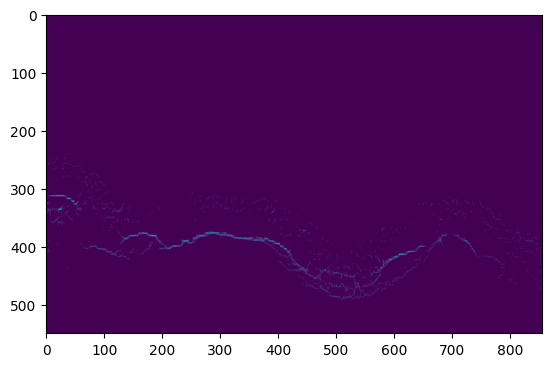

In [223]:
total_apical *= 100
total_apical[total_apical<0] = 0

plt.figure()
plt.imshow(common_functions.normalize_image(total_apical))
plt.show()

In [227]:
total_apical = Parallel(n_jobs=-1)(delayed(fucking_apical)(image_r_i, gaussian_line_r_i, angle=40, moveLine=40, plots=False) for image_r_i, gaussian_line_r_i in zip(image_r, gaussian_line_r))


In [229]:
total_apical = np.array(total_apical)

In [230]:

total_apical *= 100
total_apical[total_apical<0] = 0



In [231]:
total_apical = np.transpose(total_apical, axes=(1,2,0))

tiff.imwrite(wd+'_apical_dots_total_sum_hull_mask.tif', common_functions.normalize_image(total_apical, 255).astype(np.uint8))